In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers --upgrade

In [ ]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor, AdamW
from torch.optim import Adam
from tqdm.auto import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

In [ ]:
# Load the pretrained ViT model and processor
model_name = "google/vit-base-patch16-224-in21k"  # Pretrained ViT model
model = ViTForImageClassification.from_pretrained(model_name, num_labels=2)  # 2 classes (original, fake)

# Processor: This will handle input transformation and resizing for ViT
processor = ViTFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:

## using vut processor to make the data into its shape
# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# Custom Dataset Class
class DeepfakeDataset(Dataset):
    def __init__(self, image_dir, label, processor):
        self.image_dir = image_dir
        self.label = label
        self.processor = processor
        self.image_files = [
            f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filepath = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(filepath).convert("RGB")

        # Use the processor to handle the transformation (resize, normalization, etc.)
        encoding = self.processor(images=image, return_tensors="pt")
        label = torch.tensor(self.label)

        # Return the processed image and label
        return encoding["pixel_values"].squeeze(0), label

# Combine datasets into a single Dataset
class CombinedDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets

    def __len__(self):
        return sum(len(dataset) for dataset in self.datasets)

    def __getitem__(self, idx):
        for dataset in self.datasets:
            if idx < len(dataset):
                return dataset[idx]
            idx -= len(dataset)


train_original_path = "/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/Training_original/Training_original/Training_original"
train_fake_path = "/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/Training_fake/Training_fake/Training_fake"
val_original_path = "/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/Validation_original/Validation_original/Validation_original"
val_fake_path = "/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/Validation_fake/Validation_fake/Validation_fake"

# Create individual datasets
train_original_dataset = DeepfakeDataset(train_original_path, label=0, processor=processor)
train_fake_dataset = DeepfakeDataset(train_fake_path, label=1, processor=processor)
val_original_dataset = DeepfakeDataset(val_original_path, label=0, processor=processor)
val_fake_dataset = DeepfakeDataset(val_fake_path, label=1, processor=processor)

# Combine datasets
train_dataset = CombinedDataset([train_original_dataset, train_fake_dataset])
val_dataset = CombinedDataset([val_original_dataset, val_fake_dataset])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Example: Iterate through DataLoader
for images, labels in train_loader:
    print(f"Batch size: {images.shape}, Labels: {labels.shape}")
    break

Batch size: torch.Size([16, 3, 224, 224]), Labels: torch.Size([16])


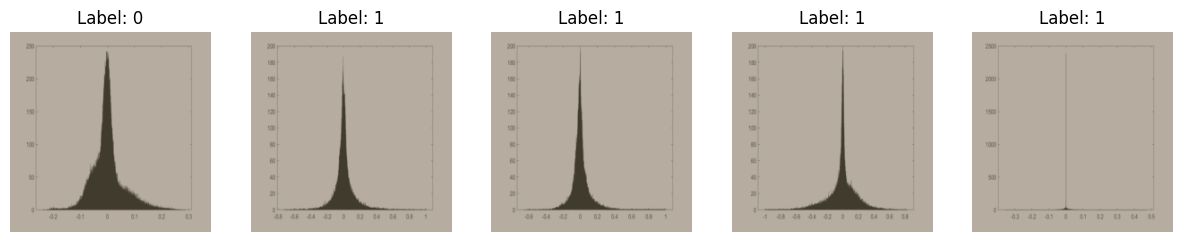

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show images in a grid
def imshow(images, labels, num_images=8):
    # Convert tensor to numpy array for plotting
    images = images.numpy()

    # Plot a grid of images (num_images = number of images to display in the grid)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    for i in range(num_images):
        ax = axes[i]
        # Unnormalize and convert to [0, 1] range for visualization
        img = images[i].transpose(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[i].item()}")  # Display the label (0 or 1)

    plt.show()

# Get a batch of images and labels from the train_loader
images, labels = next(iter(train_loader))

# Call the imshow function to display images from the batch
imshow(images, labels, num_images=5)  # Show 8 images from the batch


In [ ]:
# Set the model to training mode
model.train()

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move the model to the device

# Training loop
epochs = 3
for epoch in range(epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in loop:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the progress bar
        loop.set_postfix(loss=loss.item())

    # Validation (optional)
    model.eval()  # Set model to evaluation mode for validation
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images,  labels=labels)
            val_loss += outputs.loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions * 100
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    model.train()  # Set the model back to training mode after validation


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3:   0%|          | 0/259 [00:00<?, ?it/s]

Validation Loss: 0.1744, Accuracy: 93.89%


Epoch 2/3:   0%|          | 0/259 [00:00<?, ?it/s]

Validation Loss: 0.1606, Accuracy: 94.64%


Epoch 3/3:   0%|          | 0/259 [00:00<?, ?it/s]

Validation Loss: 0.1667, Accuracy: 94.58%


In [ ]:
model.save_pretrained("./fine_tuned_vit")
processor.save_pretrained("./fine_tuned_vit")

['./fine_tuned_vit/preprocessor_config.json']

In [ ]:
!zip -r fine_tuned_vit.zip ./fine_tuned_vit


  adding: fine_tuned_vit/ (stored 0%)
  adding: fine_tuned_vit/.ipynb_checkpoints/ (stored 0%)
  adding: fine_tuned_vit/preprocessor_config.json (deflated 46%)
  adding: fine_tuned_vit/model.safetensors (deflated 7%)
  adding: fine_tuned_vit/config.json (deflated 46%)


In [ ]:
!cp fine_tuned_vit.zip /content/drive/MyDrive/

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import os
import torch

# Paths to external test datasets
fake_dir = "/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/External_test1/External_test1/External_test1/FAKE"
original_dir = "/content/drive/MyDrive/DEEPFAKE AUDIO/k47yd3m28w-4/External_test1/External_test1/External_test1/ORIGINAL"

# Load the fine-tuned model and processor
model = ViTForImageClassification.from_pretrained("./fine_tuned_vit")
processor = ViTImageProcessor.from_pretrained("./fine_tuned_vit")

# Define a function to preprocess images and make predictions
def predict_images(image_dir, label, processor, model):
    predictions = []
    true_labels = []
    model.eval()  # Set model to evaluation mode

    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Check for image files
            filepath = os.path.join(image_dir, filename)

            # Load and preprocess the image
            image = Image.open(filepath).convert("RGB")
            inputs = processor(images=image, return_tensors="pt")

            # Run inference
            with torch.no_grad():
                outputs = model(**inputs)
                predicted_label = torch.argmax(outputs.logits, dim=-1).item()

            # Store the prediction and true label
            predictions.append(predicted_label)
            true_labels.append(label)

    return predictions, true_labels

# Predict on fake images
fake_predictions, fake_labels = predict_images(fake_dir, label=1, processor=processor, model=model)

# Predict on original images
original_predictions, original_labels = predict_images(original_dir, label=0, processor=processor, model=model)

# Combine results
all_predictions = fake_predictions + original_predictions
all_true_labels = fake_labels + original_labels

# Calculate accuracy
correct = sum([1 for pred, true in zip(all_predictions, all_true_labels) if pred == true])
total = len(all_true_labels)
accuracy = correct / total

print(f"Accuracy on the external test dataset: {accuracy * 100:.2f}%")


Accuracy on the external test dataset: 99.47%
